In [1]:
import sys
import re

strPAF_in = '/groups/tanaka/Projects/lungfish-genome/manuscript/Revision_II/winnowmap/full.paf'
strLocus = 'scaf12:230981084-231210146'
strPDF_out = '/groups/tanaka/Projects/lungfish-genome/manuscript/Revision_II/winnowmap/figure.pdf'

locus = {'chr': strLocus, 'start': 0, 'end': -1}

m = re.search('([^:]+):([0-9]+)-([0-9]+)', strLocus)
if m:
    locus['chr'] = m.group(1)
    locus['start'] = int(m.group(2))
    locus['end'] = int(m.group(3))
print(f"Extracting the data for {locus['chr']}:{locus['start']}-{locus['end']}", file=sys.stderr)

print(f'Reading the file {strPAF_in}', file=sys.stderr)
lines = []
coord_lims = [-1, -1]
with(open(strPAF_in, 'r')) as hFile:
    for line in hFile.readlines():
        readID, readLen, readStart, readEnd, readStrand, targetID, targetLen, targetStart, targetEnd, rest = line.split('\t', 9)
        if targetID == locus['chr']:
            if locus['end'] == -1:
                locus['end'] = int(targetLen)

            if coord_lims[0] == -1:
                coord_lims[0] = int(targetStart)
                coord_lims[1] = int(targetEnd)
             
            if locus['start'] <= int(targetStart) <= locus['end'] or locus['start'] <= int(targetEnd) <= locus['end']:
                lines.append([readID, readLen, readStart, readEnd, readStrand, targetID, targetLen, targetStart, targetEnd, rest])
                if int(targetStart) < coord_lims[0]:
                    coord_lims[0] = int(targetStart)
                if int(targetEnd) > coord_lims[1]:
                    coord_lims[1] = int(targetEnd)

Extracting the data for scaf12:230981084-231210146
Reading the file /groups/tanaka/Projects/lungfish-genome/manuscript/Revision_II/winnowmap/full.paf


In [3]:
# Load the BED file to display repeats
strBED = '/groups/tanaka/Projects/lungfish-genome/manuscript/Revision_II/NFOR_v3.1.repeatmasker.SCAFFOLDS.gff3'
repeats = []
with(open(strBED, 'r')) as hFile:
    for line in hFile.readlines():
        if line.startswith('#'):
            continue
        scafID, _, _, repeatStart, repeatEnd, rest = line.split('\t', 5)
        if scafID == locus['chr'] and locus['start'] <= int(repeatStart) <= locus['end'] or locus['start'] <= int(repeatEnd) <= locus['end']:
            repeats.append({'start': int(repeatStart) - coord_lims[0], 'end': int(repeatEnd) - coord_lims[0]})


7965


Text(0.5, 1.0, 'scaf12:230,981,084-231,210,146')

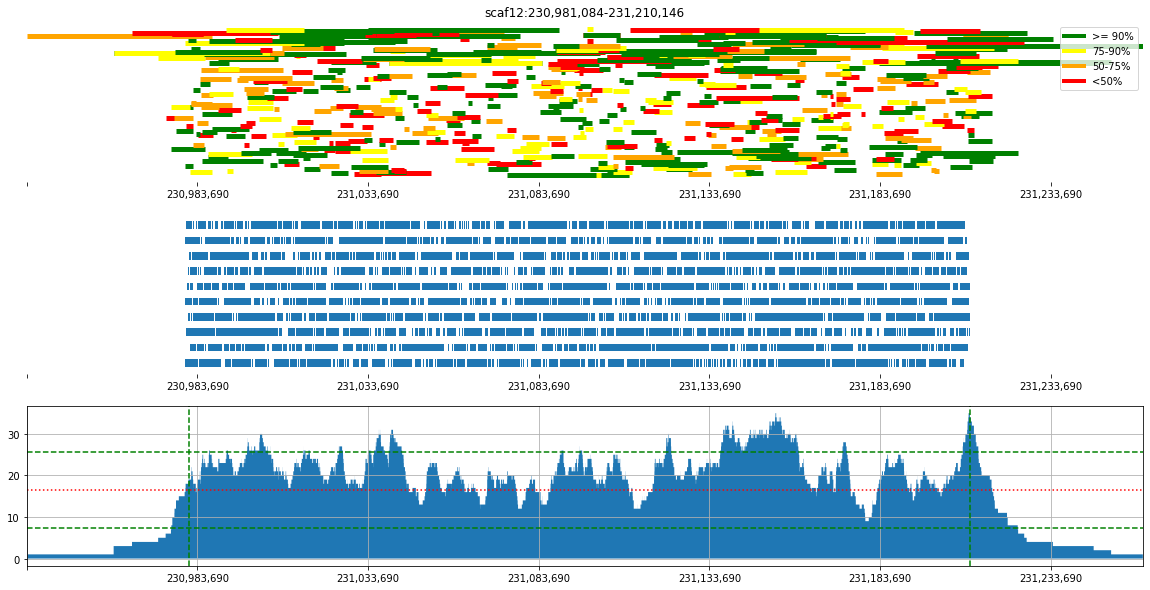

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import statistics as stats
import matplotlib
from matplotlib import collections as mc
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection

coverage = None
pos_min = -1
pos_max = -1
regions = dict()

for line in lines:
    readID, readLen, readStart, readEnd, readStrand, targetID, targetLen, targetStart, targetEnd, rest = line
    
    targetLen = str(coord_lims[1] - coord_lims[0])
    targetStart = str(int(targetStart) - coord_lims[0])
    targetEnd = str(int(targetEnd) - coord_lims[0])

    if not coverage:
        coverage = [0] * int(targetLen)

    # Make sure the aligned portion of the read is at least 10% of its length, otherwise skip the read
    if ((int(readEnd) - int(readStart)) / int(readLen) >= 0.1) and int(readEnd) - int(readStart) > 1000:
        for i in range(int(targetStart), int(targetEnd)):
            coverage[i] += 1
        if not regions.get(readID):
            regions[readID] = []
        regions[readID].append({'t_s': int(targetStart), 't_e': int(targetEnd), 'r_c': (int(readEnd) - int(readStart)) / int(readLen)})

    if pos_min == -1 or int(targetStart) < pos_min:
        pos_min = int(targetStart)

    if pos_max == -1 or int(targetEnd) > pos_max:
        pos_max = int(targetEnd)

mn = stats.mean(coverage)
sd = stats.stdev(coverage)

# Coverage track
fig, axs = plt.subplots(3,1, figsize=(20,10))
axs[2].fill_between(range(pos_min + 1, pos_max + 1), coverage)
axs[2].axhline(mn, color='red', linestyle='dotted')
axs[2].axhline(mn + sd, color='green', linestyle='dashed')
axs[2].axhline(mn - sd, color='green', linestyle='dashed')
axs[2].axvline(int(locus['start']) - coord_lims[0], linestyle='dashed', color='green')
axs[2].axvline(int(locus['end']) - coord_lims[0], linestyle='dashed', color='green')
axs[2].grid()
plt.sca(axs[2])
locs, labels = plt.xticks()
new_labels = []
for x in locs:
    if x < 1:
        new_labels.append('')
    else:
        new_labels.append(f'{int(x + coord_lims[0]):,}')
new_labels[-1] = ''
plt.xticks(locs, new_labels)
plt.xlim([pos_min, pos_max])

# Repeats track
patches = []
y = 1
for r in repeats:
    patches.append(matplotlib.patches.Rectangle((r['start'], y), r['end'] - r['start'], 0.5))
    y += 1
    if y == 11:
        y = 1
axs[1].add_collection(PatchCollection(patches))
axs[1].autoscale()
plt.sca(axs[1])
plt.xticks(locs, new_labels)
plt.xlim([pos_min, pos_max])
axs[1].set_frame_on(False)
axs[1].tick_params(left=False)
axs[1].tick_params(labelleft=False)

# Reads track
plot_lines = []
colors = []
idx = 1
for reg in regions:
    y = idx * 1
    rc = 0 # Total coverage of the current read
    for r in regions[reg]:
        plot_lines.append([(r['t_s'], y), (r['t_e'], y)])
        rc += r['r_c']
    if rc >= 0.9:
        colors.append('green')
    elif rc >= 0.75:
        colors.append('yellow')
    elif rc >= 0.5:
        colors.append('orange')
    else:
        colors.append('red')
    idx += 1
lc = mc.LineCollection(plot_lines, colors=colors, linewidths=5)
axs[0].add_collection(lc)
axs[0].autoscale()
custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='yellow', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='red', lw=4)]
axs[0].legend(custom_lines, ['>= 90%', '75-90%', '50-75%', '<50%'])
plt.sca(axs[0])
plt.xticks(locs, new_labels)
plt.xlim([pos_min, pos_max])
axs[0].set_frame_on(False)
axs[0].tick_params(left=False)
axs[0].tick_params(labelleft=False)

plt.title(f"{locus['chr']}:{locus['start']:,}-{locus['end']:,}")